In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time,datetime

from datetime import date,timedelta
import jpholiday

import seaborn as sns

from sklearn.preprocessing import StandardScaler

# 厚生労働省のHPからCSVをDL

In [2]:
positive = 'https://www.mhlw.go.jp/content/pcr_positive_daily.csv'
pcr_test = 'https://www.mhlw.go.jp/content/pcr_tested_daily.csv'
toei = pd.read_csv('./csv/toei_20201101.csv')
temp = pd.read_csv('./csv/data.csv',encoding="shift-jis",header=2)
temp = temp.iloc[1:,[0,1,4]] #余計な行列を削除

pos = pd.read_csv(positive)
pcr = pd.read_csv(pcr_test)

pos.columns = ['Date','Positive']
pcr.columns = ['Date','Test']
toei.columns = ['Date','TrainRate']
temp.columns = ['Date','Humidity','Temparature']

pos['Date'] = pd.to_datetime(pos['Date'])
pcr['Date'] = pd.to_datetime(pcr['Date'])
toei['Date'] = pd.to_datetime(toei['Date'])
temp['Date'] = pd.to_datetime(temp['Date'])

pos = pos.set_index('Date')
pcr = pcr.set_index('Date')
toei = toei.set_index('Date')
temp = temp.set_index('Date')

df = pd.concat([pos,pcr],axis=1)
df = pd.concat([df,toei],axis=1)
df = pd.concat([df,temp],axis=1)

# 乗車率の欠損値補完
# 祝日・曜日フラグ

In [3]:
df2 = df.copy()
df2.TrainRate=df2.TrainRate.interpolate()
df2.fillna(0,inplace=True)

df2['is_holiday'] = df2.index.map(jpholiday.is_holiday).astype(int)
df2['dayofweek'] = df2.index.dayofweek


# 60日前のラグ特徴量作成

In [4]:
df3 = df2.copy()
df3['Date'] = df3.index + timedelta(days=60)
df3 = df3.set_index('Date')
df3.columns = ['Positive_lag60','Test_lag60','TrainRate_lag60','Humidity_lag60',
              'Temparature_lag60','is_holiday_lag60','dayofweek_lag60']

df3['Positive']= df2['Positive']

In [7]:
df3

,Positive_lag60,Test_lag60,TrainRate_lag60,Humidity_lag60,Temparature_lag60,is_holiday_lag60,dayofweek_lag60,Positive
Date,,,,,,,,
2020-03-01,0.0,0.0,0.00,49.0,5.5,1,2,15.0
2020-03-02,0.0,0.0,0.00,60.0,6.2,0,3,14.0
2020-03-03,0.0,0.0,0.00,63.0,6.1,0,4,16.0
2020-03-04,0.0,0.0,0.00,53.0,7.2,0,5,33.0
2020-03-05,0.0,0.0,0.00,61.0,5.4,0,6,31.0
...,...,...,...,...,...,...,...,...
2021-01-10,1535.0,33681.0,-30.34,48.0,11.9,0,2,NaN
2021-01-11,1623.0,29912.0,-30.34,63.0,10.2,0,3,NaN
2021-01-12,1704.0,24038.0,-30.34,67.0,13.7,0,4,NaN


<AxesSubplot:>

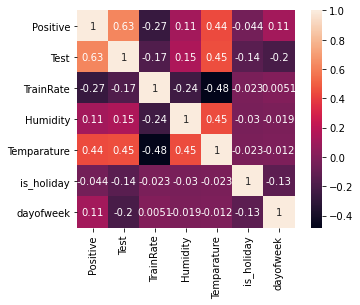

In [11]:
corr = df2.corr()
sns.heatmap(corr,square=True,annot=True)

# StandardScalerでグラフ描画

In [31]:
scaler = StandardScaler()
df4 = scaler.fit_transform(df2)
df4 = pd.DataFrame(df4)
df4.columns = df2.columns
df4.index = df2.index
df4

,Positive,Test,TrainRate,Humidity,Temparature,is_holiday,dayofweek
Date,,,,,,,
2020-01-01,-0.901094,-0.805825,1.724220,-1.410062,-1.578407,4.221792,-0.508823
2020-01-02,-0.901094,-0.805825,1.724220,-0.750296,-1.486175,-0.236866,-0.007828
2020-01-03,-0.901094,-0.805825,1.724220,-0.570360,-1.499351,-0.236866,0.493167
2020-01-04,-0.901094,-0.805825,1.724220,-1.170147,-1.354415,-0.236866,0.994162
2020-01-05,-0.901094,-0.805825,1.724220,-0.690318,-1.591583,-0.236866,1.495156
...,...,...,...,...,...,...,...
2020-11-11,2.855983,2.364480,0.148129,-1.470041,-0.735141,-0.236866,-0.508823
2020-11-12,3.071373,2.009714,0.148129,-0.570360,-0.959133,-0.236866,-0.007828
2020-11-13,3.269629,1.456810,0.148129,-0.330445,-0.497972,-0.236866,0.493167


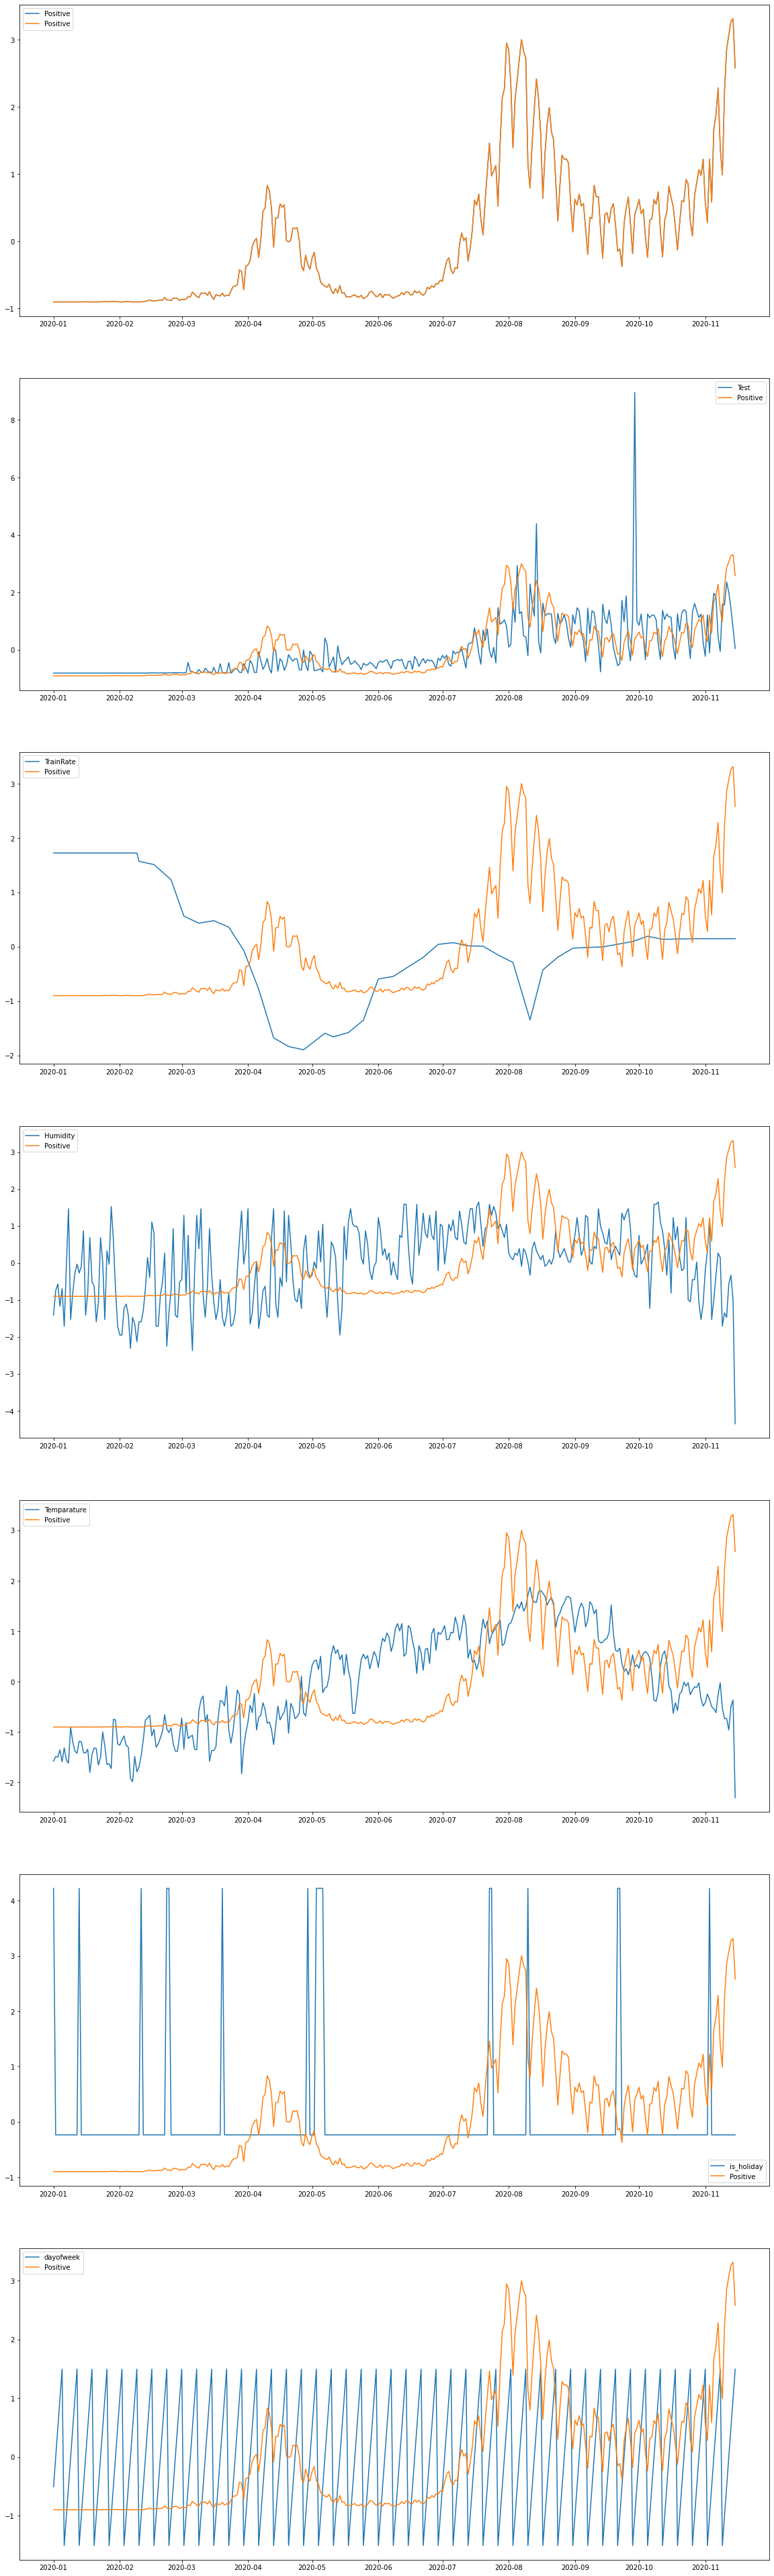

In [38]:
plt.figure(figsize=(20,70))
for ncol,colname in enumerate(df4.columns):
    plt.subplot(7,1,ncol+1)
    plt.plot(df4[colname])
    plt.plot(df4['Positive'])
    plt.legend(labels=[colname,'Positive'])